In [5]:
import pyro.distributions as dist
from pyro.distributions import TorchDistribution
import pyro
import torch
import numpy as np
import matplotlib.pyplot as plt
from typing import Any

# seed = 42
# torch.manual_seed(seed)

### Necessary functions

In [6]:
def PlotDistribution(distribution: pyro.distributions.Distribution, num_samples: int = 1000) -> None:
    """
    Samples from a 2D distribution and visualizes it on a plane.

    Parameters:
    - distribution: A 2D distribution object from torch.distributions.
    - num_samples: The number of samples to visualize (default is 1000).
    """
    samples = distribution.sample((num_samples,))

    samples_np = samples.numpy()

    plt.figure(figsize=(8, 6))
    plt.scatter(samples_np[:, 0], samples_np[:, 1], alpha=0.5)
    plt.title('2D Distribution Sampling')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.grid(True)
    plt.show()

### LogisticNormal

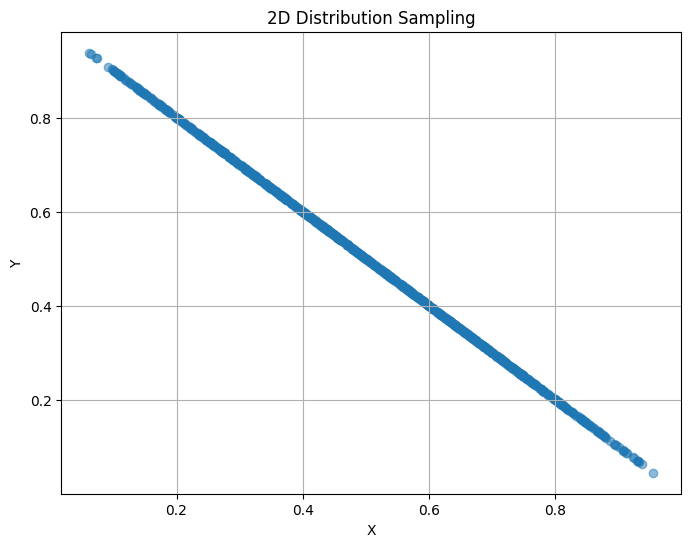

In [7]:
loc = torch.tensor([0.0])
scale = torch.tensor([1.0])
LogisticNormal = dist.LogisticNormal(loc, scale)

PlotDistribution(LogisticNormal)

In [8]:
print(LogisticNormal.rsample())
print(LogisticNormal.sample())

tensor([0.9249, 0.0751])
tensor([0.4778, 0.5222])


### RelaxedBernoulli
- temperature (Tensor) – relaxation temperature

- probs (Number, Tensor) – the probability of sampling 1

- logits (Number, Tensor) – the log-odds of sampling 1

In [9]:
RelaxedBernoulli = dist.RelaxedBernoulli(temperature=torch.tensor([0.01]), probs=torch.tensor([0.1, 0.2, 0.3, 0.99]))

In [10]:
print(RelaxedBernoulli.rsample())
print(RelaxedBernoulli.sample())

tensor([1.1755e-38, 1.1755e-38, 1.0000e+00, 1.0000e+00])
tensor([1.1755e-38, 1.1755e-38, 9.5771e-01, 1.0000e+00])


### [How to add new distribution](https://docs.pyro.ai/en/stable/distributions.html?#torchdistribution)

In [14]:
import torch
from pyro.distributions import TorchDistribution
from pyro.distributions.util import broadcast_shape

class MyNormalDistribution(TorchDistribution):
    """
    Normal distribution parameterized by a location (mean) and scale (standard deviation).

    Args:
        loc (torch.Tensor): The mean of the distribution.
        scale (torch.Tensor): The standard deviation of the distribution.
        validate_args (bool, optional): Whether to validate input arguments. Defaults to None.

    Attributes:
        loc (torch.Tensor): The mean of the distribution.
        scale (torch.Tensor): The standard deviation of the distribution.
        batch_shape (torch.Size): The batch shape of the distribution.
        event_shape (torch.Size): The event shape of the distribution.
        has_rsample (bool): Indicates that the distribution supports reparameterized sampling.

    Methods:
        rsample(sample_shape: torch.Size = torch.Size()) -> torch.Tensor:
            Generates a sample from the distribution using the reparameterization trick.
        log_prob(value: torch.Tensor) -> torch.Tensor:
            Computes the log probability of the given value.
        expand(batch_shape: Tuple[int, ...], _instance=None) -> Normal:
            Returns a new distribution instance with expanded batch dimensions.

    Properties:
        mean (torch.Tensor): The mean of the distribution.
        variance (torch.Tensor): The variance of the distribution.
        stddev (torch.Tensor): The standard deviation of the distribution.
    """

    arg_constraints = {}
    has_rsample = True

    def __init__(self, loc: torch.Tensor, scale: torch.Tensor, validate_args: bool = None):
        self.loc = loc
        self.scale = scale
        batch_shape = broadcast_shape(loc.shape, scale.shape)
        event_shape = torch.Size([])
        super().__init__(batch_shape, event_shape, validate_args=validate_args)

    def rsample(self, sample_shape: torch.Size = torch.Size()) -> torch.Tensor:
        """
        Generates a sample from the distribution using the reparameterization trick.

        Args:
            sample_shape (torch.Size, optional): The shape of the sample. Defaults to torch.Size().

        Returns:
            torch.Tensor: A sample from the distribution.
        """
        shape = self._extended_shape(sample_shape)
        eps = torch.randn(shape, dtype=self.loc.dtype, device=self.loc.device)
        return self.loc + eps * self.scale

    def log_prob(self, value: torch.Tensor) -> torch.Tensor:
        """
        Computes the log probability of the given value.

        Args:
            value (torch.Tensor): The value for which to compute the log probability.

        Returns:
            torch.Tensor: The log probability of the given value.
        """
        if self._validate_args:
            self._validate_sample(value)
        var = (self.scale ** 2)
        log_scale = self.scale.log()
        return -((value - self.loc) ** 2) / (2 * var) - log_scale - 0.5 * torch.tensor(2 * torch.pi).log()

    @property
    def mean(self) -> torch.Tensor:
        """
        The mean of the distribution.

        Returns:
            torch.Tensor: The mean of the distribution.
        """
        return self.loc

    @property
    def variance(self) -> torch.Tensor:
        """
        The variance of the distribution.

        Returns:
            torch.Tensor: The variance of the distribution.
        """
        return self.scale ** 2

    @property
    def stddev(self) -> torch.Tensor:
        """
        The standard deviation of the distribution.

        Returns:
            torch.Tensor: The standard deviation of the distribution.
        """
        return self.scale

In [33]:
loc = torch.tensor([0.0, 5.0])
scale = torch.tensor([1.0, 2.0])

MyNormal = MyNormalDistribution(loc, scale)

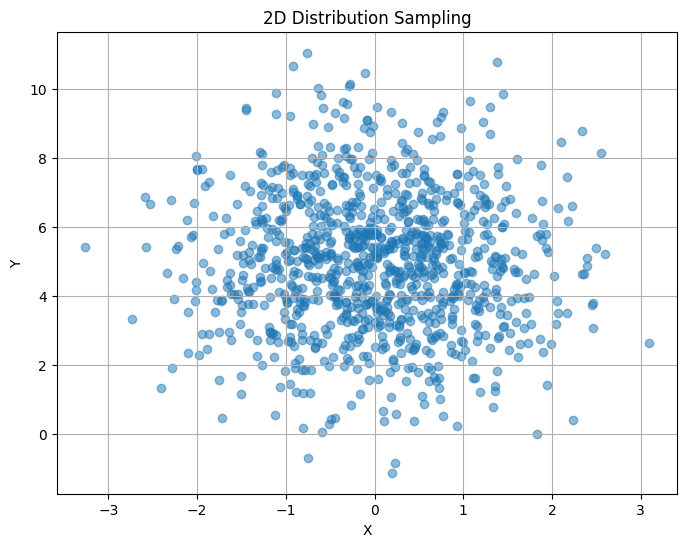

In [34]:
PlotDistribution(MyNormal)